# Inference

- Run inference on the test dataset.
- Mainly for testing your model is doing ok visually.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Synthetic_Cells")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

In [ ]:
# Select the model
model_name = '2018.11.07-09:37:48'
model_path = model_dir / model_name

# Set some configurations
config['MODEL']['DEVICE'] = "cuda"
config['DATALOADER']['NUM_WORKERS'] = 4
config['TEST']['IMS_PER_BATCH'] = 1
config['SOLVER']['IMS_PER_BATCH'] = 1
batch_to_load = 8

# Build the model
model = maskflow.inference.build_model(config, model_path)

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=False)
data = [datum for _, datum in zip(range(batch_to_load), data_loader)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

# Run inference
predictions = []
images = []
ground_truth = []
for batch_image, batch_target, batch_idx in data:
    batch_image = batch_image.to(config['MODEL']['DEVICE'])
    with torch.no_grad():
        prediction = model(batch_image)
        prediction = [o.to('cpu') for o in prediction]
        predictions.extend(prediction)
        images.extend([im for im in batch_image.tensors])
        ground_truth.extend(batch_target)
        
images = np.array([o.to('cpu').numpy() for o in images])
len(images)

7
tensor([0.9877, 0.9721, 0.9656, 0.9016, 0.8567, 0.7288, 0.7282])


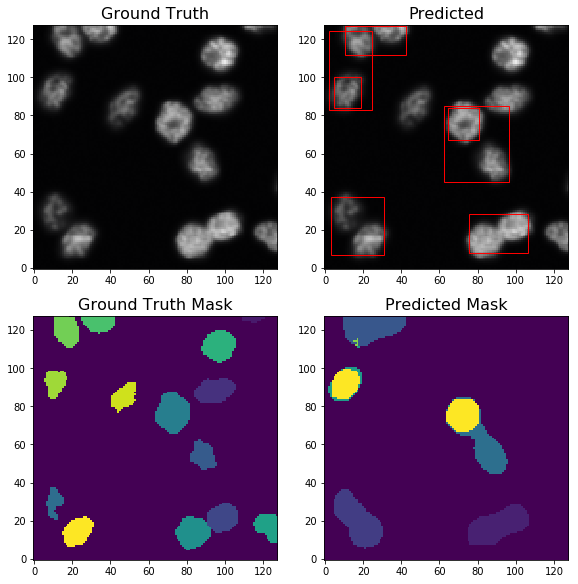

In [11]:
# Show prediction
idx = 3
image = images[idx]
prediction = predictions[idx]
gt = ground_truth[idx]

prediction = maskflow.inference.select_top_predictions(prediction, confidence_threshold=0.7)

print(prediction.bbox.shape[0])
print(prediction.get_field('scores'))

_ = maskflow.viz.display_prediction_and_gt(image, prediction, gt,
                                           class_names=config['CLASS_NAMES'],
                                           pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                           pixel_std=config['INPUT']['PIXEL_STD'])